In [2]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread

import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random

random.seed(100)

---

### Data Visualization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
breast_imgs_b = glob.glob('/content/drive/MyDrive/Dataset2/FNA/benign/**/*.png', recursive = True)
breast_imgs_m = glob.glob('/content/drive/MyDrive/Dataset2/FNA/malignant/**/*.png', recursive = True)
breast_imgs_test = glob.glob('/content/drive/MyDrive/Dataset2/test/**/*.png', recursive = True)

In [4]:
benign_imgs = []
malignant_imgs = []
test_imgs = []
for img in breast_imgs_b:
    benign_imgs.append(img)

for img in breast_imgs_m:
    malignant_imgs.append(img)

for img in breast_imgs_test:
    test_imgs.append(img)

In [5]:
benign_num = len(benign_imgs)
malignant_num = len(malignant_imgs)

total_img_num = benign_num + malignant_num

print('Number of benign images : {}' .format(benign_num))
print('Number of malignant images : {}' .format(malignant_num))
print('Total Number of Images : {}' .format(total_img_num))

Number of benign images : 1074
Number of malignant images : 650
Total Number of Images : 1724


In [11]:
data_insight_1 = pd.DataFrame({'state of cancer' : ['benign','malignant'],'Numbers of Patients' : [1074,650]})

In [12]:
bar = px.bar(data_frame=data_insight_1, x = 'state of cancer', y='Numbers of Patients', color='state of cancer')
bar.update_layout(title_text='Number of Patients with benign and maligant', title_x=0.5)
bar.show()

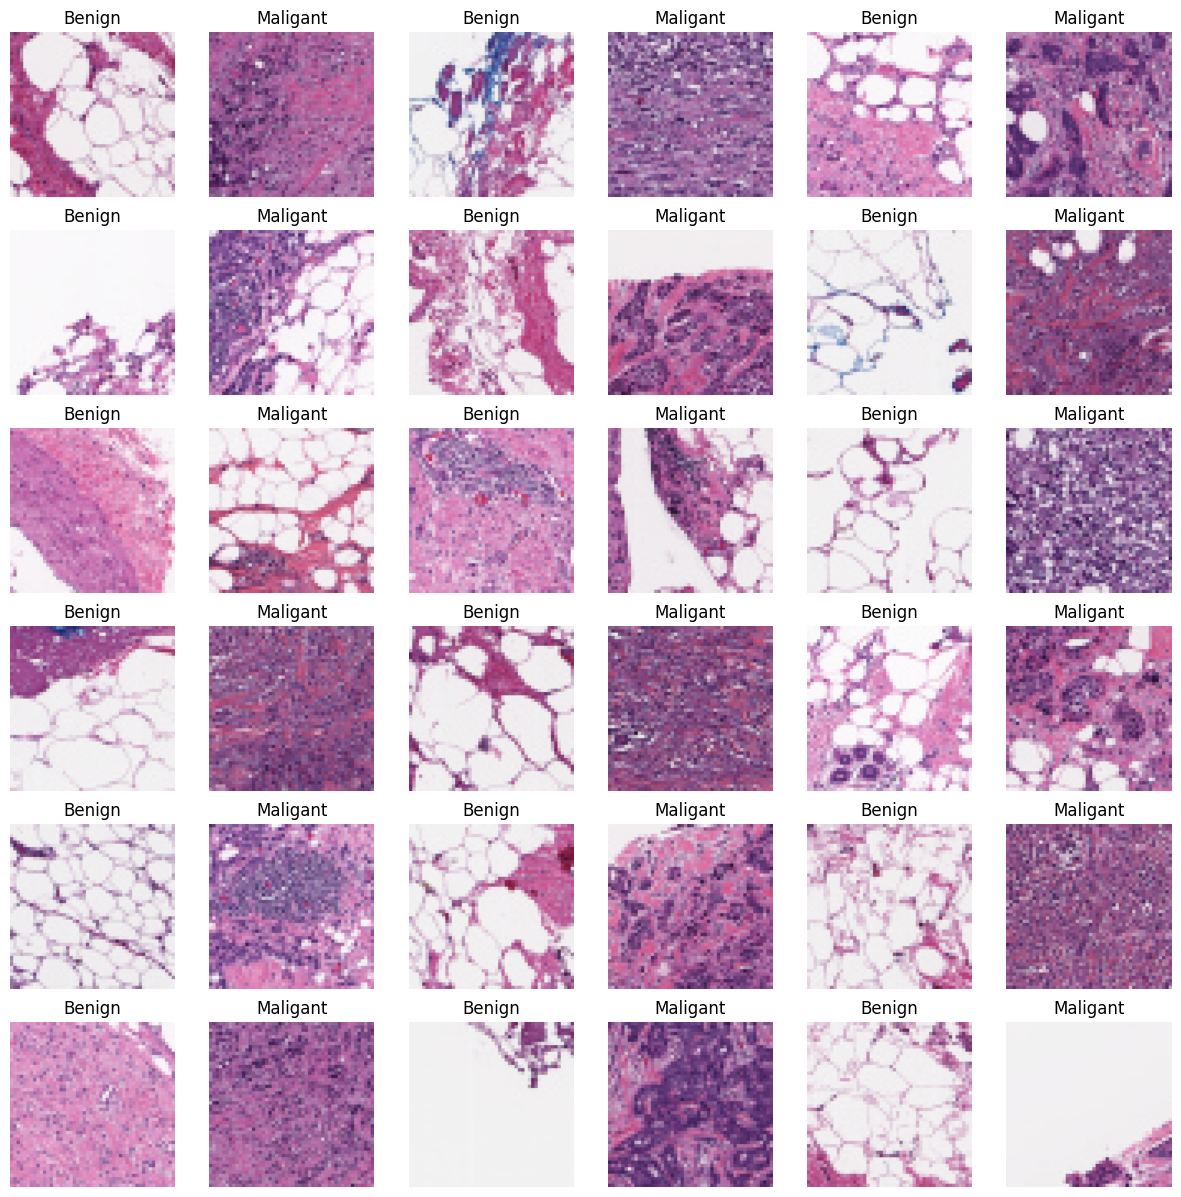

In [14]:
plt.figure(figsize = (15, 15))

some_b = np.random.randint(0, len(benign_imgs), 18)
some_m = np.random.randint(0, len(malignant_imgs), 18)

s = 0
for num in some_b:

        img = image.image_utils.load_img((benign_imgs[num]), target_size=(100, 100))
        img = image.image_utils.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('Benign')
        plt.imshow(img.astype('uint8'))
        s += 1

s = 1
for num in some_m:

        img = image.image_utils.load_img((malignant_imgs[num]), target_size=(100, 100))
        img = image.image_utils.img_to_array(img)
        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('Maligant')
        plt.imshow(img.astype('uint8'))
        s += 1

---
### Data Modeling

In [15]:
some_b_img = random.sample(benign_imgs, len(benign_imgs))
some_m_img = random.sample(malignant_imgs, len(malignant_imgs))
some_test_img = random.sample(test_imgs, len(test_imgs))
b_arr = []
m_arr = []
test_arr = []
# Loop through each image in the 'some_non_img' list
for img in some_b_img:
    b_img = cv2.imread(img, cv2.IMREAD_COLOR)
    b_img_size = cv2.resize(b_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    b_arr.append([b_img_size, 0])

# Loop through each image in the 'some_can_img' list
for img in some_m_img:
    m_img = cv2.imread(img, cv2.IMREAD_COLOR)
    m_img_size = cv2.resize(m_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    m_arr.append([m_img_size, 1])

# Loop through each image in the 'some_test_img' list

for img in some_test_img:
    test_img = cv2.imread(img, cv2.IMREAD_COLOR)
    test_img_size = cv2.resize(test_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    test_arr.append(test_img_size)

In [16]:
X = []  # List for image data
y = []  # List for labels

# Concatenate the arrays 'non_img_arr' and 'can_img_arr' into a single array 'breast_img_arr'
breast_img_arr = np.concatenate((b_arr, m_arr))

# Shuffle the elements in the 'breast_img_arr' array randomly
random.shuffle(breast_img_arr)

# Loop through each element (feature, label) in the shuffled 'breast_img_arr'
for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

# Convert the lists 'X' and 'y' into NumPy arrays
X = np.array(X)
y = np.array(y)
test_data = np.array(test_arr)

# Print the shape of the 'X' array
print('X shape: {}'.format(X.shape))

X shape: (1724, 50, 50, 3)


<__array_function__ internals>:180: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [21]:
# Split the dataset into training and testing sets, with a test size of 20%
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
# Print the shape of the training and testing sets
print('X_train shape : {}' .format(X_train.shape))
print('X_valid shape : {}' .format(X_valid.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_valid shape : {}' .format(y_valid.shape))

X_train shape : (1379, 50, 50, 3)
X_valid shape : (345, 50, 50, 3)
y_train shape : (1379, 1)
y_valid shape : (345, 1)


In [18]:
# Define an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True
)

# Define a ReduceLROnPlateau callback
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_delta=1e-7,
    cooldown=0,
    verbose=1
)

In [23]:
tf.random.set_seed(42)

# Create a Sequential model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(strides=2),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 50, 50, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 25, 25, 64)       256       
 hNormalization)                                                 
                                                      

In [24]:
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_valid, y_valid),
                    epochs = 25,
                    batch_size = 75,
                    callbacks=[early_stopping, plateau])

Epoch 1/25
19/19 [==============================] - 19s 879ms/step - loss: 0.3178 - accuracy: 0.9326 - val_loss: 2.7645 - val_accuracy: 0.9072 - lr: 0.0010
Epoch 2/25
19/19 [==============================] - 13s 654ms/step - loss: 0.1124 - accuracy: 0.9674 - val_loss: 1.4923 - val_accuracy: 0.9072 - lr: 0.0010
Epoch 3/25
19/19 [==============================] - 17s 893ms/step - loss: 0.0633 - accuracy: 0.9761 - val_loss: 0.8736 - val_accuracy: 0.9072 - lr: 0.0010
Epoch 4/25
19/19 [==============================] - 16s 858ms/step - loss: 0.0577 - accuracy: 0.9797 - val_loss: 0.7665 - val_accuracy: 0.9072 - lr: 0.0010
Epoch 5/25
19/19 [==============================] - 13s 681ms/step - loss: 0.0440 - accuracy: 0.9869 - val_loss: 0.6168 - val_accuracy: 0.9072 - lr: 0.0010
Epoch 6/25
19/19 [==============================] - 17s 871ms/step - loss: 0.0444 - accuracy: 0.9833 - val_loss: 0.8537 - val_accuracy: 0.9072 - lr: 0.0010
Epoch 7/25
19/19 [==============================] - 17s 908ms/st

In [25]:
model.evaluate(X_valid,y_valid)

11/11 [==============================] - 1s 65ms/step - loss: 0.0447 - accuracy: 0.9884


[0.04466092586517334, 0.9884058237075806]

11/11 [==============================] - 2s 143ms/step


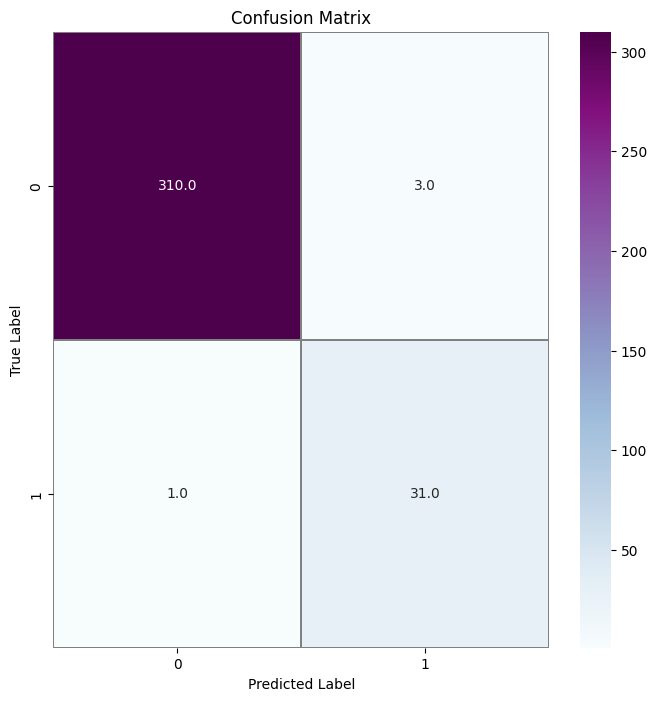

In [27]:
Y_pred = model.predict(X_valid)
Y_pred_classes = np.where(Y_pred>0.5,1,0)


confusion_mtx = confusion_matrix(y_valid, Y_pred_classes)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

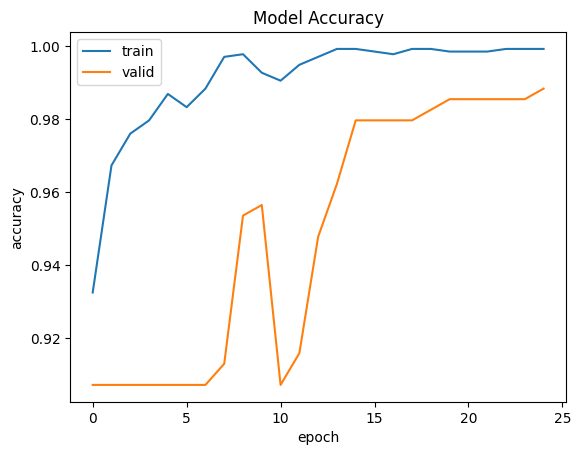

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

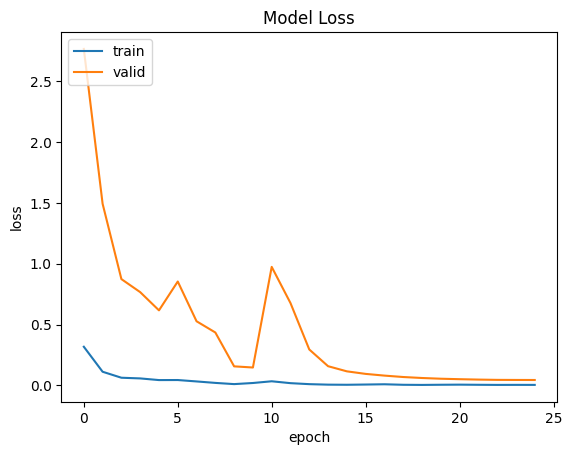

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [36]:
prediction = model.predict(test_data)
prediction = np.where(prediction>0.5,1,0)
for i in range(len(breast_imgs_test)):
  print(breast_imgs_test[i],prediction[i])

1/1 [==============================] - 0s 159ms/step
/content/drive/MyDrive/Dataset2/test/two.png [1]
/content/drive/MyDrive/Dataset2/test/one.png [0]
/content/drive/MyDrive/Dataset2/test/five.png [1]
/content/drive/MyDrive/Dataset2/test/six.png [1]
/content/drive/MyDrive/Dataset2/test/seven.png [0]
/content/drive/MyDrive/Dataset2/test/ten.png [1]
/content/drive/MyDrive/Dataset2/test/twelve.png [0]
/content/drive/MyDrive/Dataset2/test/three.png [0]
/content/drive/MyDrive/Dataset2/test/fourteen.png [0]
/content/drive/MyDrive/Dataset2/test/nine.png [1]
/content/drive/MyDrive/Dataset2/test/eleven.png [0]
/content/drive/MyDrive/Dataset2/test/thirteen.png [1]
/content/drive/MyDrive/Dataset2/test/four.png [1]
/content/drive/MyDrive/Dataset2/test/eight.png [0]


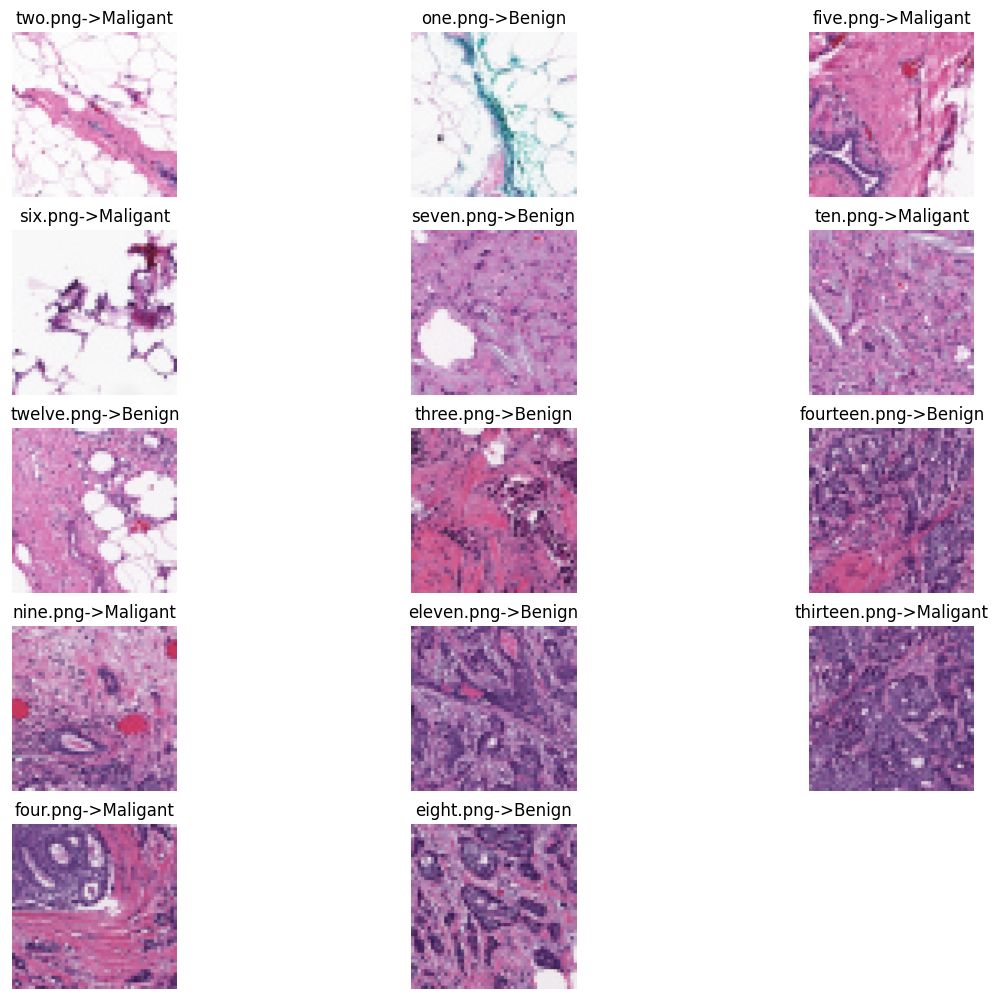

In [45]:
plt.figure(figsize = (15, 15))

s = 0
for img in test_imgs:

        img = image.image_utils.load_img(img, target_size=(100, 100))
        img = image.image_utils.img_to_array(img)
        name=breast_imgs_test[s]
        name=name[37:]
        x=name+'->Benign'
        y=name+'->Maligant'
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        if(prediction[s]==0):
           plt.title(x)
        if(prediction[s]==1):
           plt.title(y)
        plt.imshow(img.astype('uint8'))
        s += 1